In [1]:
import matplotlib.pyplot as plt
import cv2
import pywt
import numpy as np
%matplotlib inline

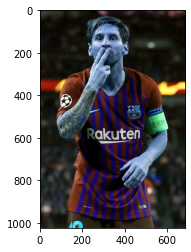

In [73]:
img = cv2.imread('./Dataset/maria_sharapova/sharapova-hits-the-practice-courts-and-met-ball-kids.jpg')
plt.imshow(img)

In [3]:
np.shape(img)

(555, 700, 3)

In [4]:
img.shape

(555, 700, 3)

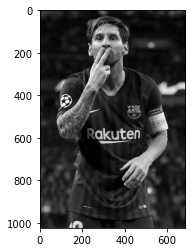

In [79]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')

In [6]:
gray_img.shape

(555, 700)

## Calling in Haar cascade classifier for face and eye detection


In [7]:
face_cascade = cv2.CascadeClassifier(r'C:\Users\TR3X\anaconda3\envs\sportceleb\Library\etc\haarcascades\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(r'C:\Users\TR3X\anaconda3\envs\sportceleb\Library\etc\haarcascades\haarcascade_eye.xml')

In [8]:
face_rectangle = face_cascade.detectMultiScale(gray_img, 1.2, 5)
face_rectangle
(x,y,w,h) = face_rectangle[0]

In [9]:
x,y,w,h

(357, 39, 231, 231)

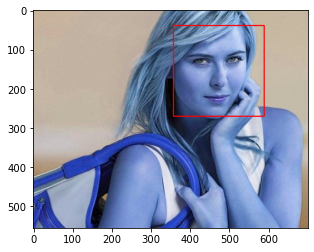

In [10]:
face_detected = cv2.rectangle(img, (x, y), (x+w, y+h),(255, 0, 0), 2)
plt.imshow(face_detected)
face_detected = face_detected[y:y+h, x:x+w]

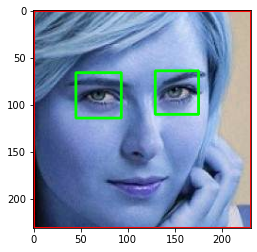

In [11]:
eyes = eye_cascade.detectMultiScale(face_detected, 1.2, 5)
for (ex, ey, ew, eh) in eyes:
    cv2.rectangle(face_detected, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

plt.imshow(face_detected)

## After we get the cropped photo with face and eye recognized, we will export the cropped image (non rectangular) it to a folder named "cropped" and dynamically create folders for each of the celebrities we want to train our model with.

In [2]:
import os

In [17]:
l = []
for entry in os.scandir('./Dataset/'):
    l.append(entry.path)
print(l)

['./Dataset/cropped', './Dataset/lionel_messi', './Dataset/maria_sharapova', './Dataset/roger_federer', './Dataset/serena_williams', './Dataset/virat_kohli']


In [14]:
dataset_path = './Dataset/'
path_to_write = dataset_path + 'cropped/'

In [15]:
if not os.path.isdir(path_to_write):
    os.makedirs(path_to_write)
cv2.imwrite('imagetest.jpg', face_detected)  

True

## Function that takes in images and checks for face and eye, then based on the condition below saves the cropped image

In [36]:
#This function crops out the face if and only if there are more than 2 eyes detected.
#Incase there are less than 2 eyes, it returns nothing
#image_path is the celebrity picture path

def cropped_images_with_face_and_eye(image_path):
    color_img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(r'C:\Users\TR3X\anaconda3\envs\sportceleb\Library\etc\haarcascades\haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(r'C:\Users\TR3X\anaconda3\envs\sportceleb\Library\etc\haarcascades\haarcascade_eye.xml')
    faces_detected = face_cascade.detectMultiScale(gray_img, 1.2, 5)
    for (x, y, w, h) in faces_detected:
        cropped_gray_face = gray_img[y:y+h, x:x+w]
        cropped_color_face = color_img[y:y+h, x:x+w]
        eyes_detected = eye_cascade.detectMultiScale(cropped_gray_face, 1.2, 5)
        if len(eyes_detected) >= 2:
            return cropped_color_face

In [77]:
func_image = cropped_images_with_face_and_eye('./Dataset/lionel_messi/02453493f852c0efe8ff951dea5845c4.jpg')

In [52]:
cv2.imwrite('img.jpg', func_image)

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgcodecs\src\loadsave.cpp:803: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [41]:
os.path.isdir('./Dataset/lionel_messi/xy')

False

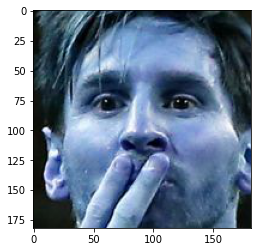

In [37]:
k = cropped_images_with_face_and_eye('./Dataset/lionel_messi/02453493f852c0efe8ff951dea5845c4.jpg')
plt.imshow(k)

## Below code snippet will create a folder named "cropped" and create individual folder for each of the sport celebrities and save the cropped versions of their pictures in the respective folders.

## Incase of the folder pre-exists, it will delete the "cropped" folder and start from fresh

In [117]:
import shutil
if os.path.isdir(path_to_write):
    shutil.rmtree(path_to_write)
    
celebrity_list = []
count = 0
celebrity_list = os.scandir(dataset_path)
for i in celebrity_list:
    print(f'Cropping for {i.name} ...')
    for j in os.scandir(i.path + '/'):
        img_array = cropped_images_with_face_and_eye(j.path)
        if not os.path.isdir(path_to_write):
            os.mkdir(path_to_write)
        if not os.path.isdir(path_to_write + i.path.split('/')[-1] + '/'):
            os.mkdir(path_to_write + i.path.split('/')[-1] + '/')
        if img_array is not None:
            count+=1
            cv2.imwrite(path_to_write + i.path.split('/')[-1] + '/' + i.name + str(count) + '.png', img_array)
print("Done")

Cropping for lionel_messi ...
Cropping for maria_sharapova ...
Cropping for roger_federer ...
Cropping for serena_williams ...
Cropping for virat_kohli ...
Done


# Step2: Feature Engineering

### • We will now apply wavelet transform to each of our cropped images
### • Once we apply WT, we will vstack the original color image (3 channels) with the WTransformed image and feed it to the model input for training

In [34]:
celebrity_dict = {}
images_path = []

for x in os.scandir('./Dataset/cropped/'):
    for y in os.scandir('./Dataset/cropped/' + x.name + '/'):
        images_path.append(y.path)
    celebrity_dict[x.name] = images_path.copy()
    images_path.clear()
celebrity_dict

{'lionel_messi': ['./Dataset/cropped/lionel_messi/lionel_messi1.png',
  './Dataset/cropped/lionel_messi/lionel_messi10.png',
  './Dataset/cropped/lionel_messi/lionel_messi11.png',
  './Dataset/cropped/lionel_messi/lionel_messi12.png',
  './Dataset/cropped/lionel_messi/lionel_messi13.png',
  './Dataset/cropped/lionel_messi/lionel_messi14.png',
  './Dataset/cropped/lionel_messi/lionel_messi15.png',
  './Dataset/cropped/lionel_messi/lionel_messi16.png',
  './Dataset/cropped/lionel_messi/lionel_messi17.png',
  './Dataset/cropped/lionel_messi/lionel_messi18.png',
  './Dataset/cropped/lionel_messi/lionel_messi19.png',
  './Dataset/cropped/lionel_messi/lionel_messi2.png',
  './Dataset/cropped/lionel_messi/lionel_messi20.png',
  './Dataset/cropped/lionel_messi/lionel_messi21.png',
  './Dataset/cropped/lionel_messi/lionel_messi23.png',
  './Dataset/cropped/lionel_messi/lionel_messi24.png',
  './Dataset/cropped/lionel_messi/lionel_messi25.png',
  './Dataset/cropped/lionel_messi/lionel_messi26.pn

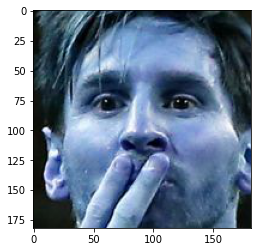

In [38]:
k = cropped_images_with_face_and_eye('./Dataset/lionel_messi/02453493f852c0efe8ff951dea5845c4.jpg')
plt.imshow(k)

## Code for Wavelet transform

In [39]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

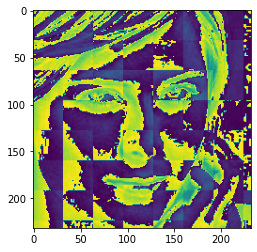

In [45]:
k = cropped_images_with_face_and_eye('./Dataset/maria_sharapova/sharapova-hits-the-practice-courts-and-met-ball-kids.jpg')
wt = w2d(k, 'db1', 5)
plt.imshow(wt)

In [44]:
celeb_1_hot = {}
count = 0
for celeb in celebrity_dict.keys():
    celeb_1_hot[celeb] = count
    count+=1
celeb_1_hot

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

## Making our training dataset

In [48]:
X = []
y = []
for celeb, image in celebrity_dict.items():
    for i in image:
        raw_img = cv2.imread(i)
        scaled_raw_img = cv2.resize(raw_img, (32, 32))
        wavelet_transformed_img = w2d(raw_img, 'db1', 5)
        scaled_wavelet_transformed_img = cv2.resize(wavelet_transformed_img, (32, 32))
        combined_image = np.vstack((scaled_raw_img.reshape(32*32*3, 1), scaled_wavelet_transformed_img.reshape(32*32, 1)))
        X.append(combined_image)
        y.append(celeb_1_hot[celeb])

In [49]:
len(X)

131

In [50]:
len(X[0])

4096

In [51]:
X[0]

array([[ 31],
       [ 39],
       [ 37],
       ...,
       [117],
       [211],
       [215]], dtype=uint8)

In [52]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(131, 4096)

In [54]:
X[0]

array([ 31.,  39.,  37., ..., 117., 211., 215.])

In [55]:
len(y)

131

## Training SVM model with rbf kernel initially and seeing how it performs

Later on we will try to improve the accuracy using GridSearchCV

In [59]:
!pip install scikit-learn

In [61]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe = Pipeline((('scaler', StandardScaler()), ('svc', SVC(C= 10))))  
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8181818181818182

In [65]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.88      0.88      0.88         8
           2       0.67      0.33      0.44         6
           3       0.80      0.80      0.80         5
           4       0.71      1.00      0.83         5

    accuracy                           0.82        33
   macro avg       0.79      0.80      0.78        33
weighted avg       0.81      0.82      0.80        33



## Trying GridSearchCV to get the best model and best parameters for the best model

We will try to see which model among SVC, Random forest, Logistic Regression performs the best

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import svm

In [92]:
model_params = {
    'svm' : {
        'model' : SVC(gamma='auto', probability=True),
        'params' : {
            'svc__C' : [1, 10, 15, 20, 100, 1000],
            'svc__kernel' : ['rbf', 'linear']
        }
    },
        
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators' : [1, 5, 10, 50, 100]
        }
    },
        
    'logistic_regression' : {
        'model' : LogisticRegression(solver='liblinear', multi_class='auto'),
        'params' : {
            'logisticregression__C' : [1, 10, 100, 1000]
        }        
    }
}

In [97]:
scores = []
best_estimators = {}
import pandas as pd

for algo, params in model_params.items():
    pipe = make_pipeline(StandardScaler(), params['model'])
    clf = GridSearchCV(pipe, params['params'], cv=5)
    clf.fit(X_train, y_train)
    scores.append({
        'model' : algo,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.776842,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.766842,{'randomforestclassifier__n_estimators': 100}
2,logistic_regression,0.837368,{'logisticregression__C': 1}


In [98]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [99]:
best_estimators['svm'].score(X_test, y_test)

0.9393939393939394

In [101]:
best_estimators['svm'].score(X_train, y_train)

1.0

In [100]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.8787878787878788

## Going ahead with SVM model

Here we see that the training and testing scores are quite good which means that the model is best fitting the dataset. I agree we see 100% on the training data but we also are able to get 94% on the test data. P.S. - There is no data leakage

In [102]:
best_clf = best_estimators['svm']

In [103]:
!pip install seaborn

Text(33.0, 0.5, 'Actual')

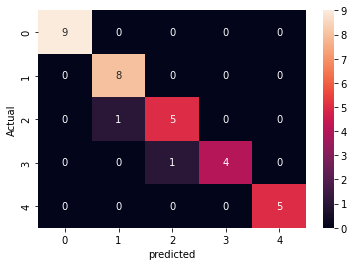

In [106]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
sns.heatmap(cm, annot= True)
plt.xlabel('predicted')
plt.ylabel('Actual')

## Saving the Trained model

In [107]:
!pip install joblib

In [108]:
import joblib
joblib.dump(best_clf, 'face_recog_model_svm.pkl')

['face_recog_model_svm.pkl']

## Saving the celebrity class dictionary as json

In [110]:
import json
with open('class_dict.json', 'w') as f:
    f.write(json.dumps(celeb_1_hot))